In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import seaborn as sns
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from src.config import  PAIRED_SAMPLES, get_experiment_artifacts

In [3]:
sns.set_theme(style="white", palette="muted")
sns.set_context("paper", font_scale = 1.3)

plt.rcParams['text.usetex'] = True

import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True


In [4]:
def consistency(x, change_df, sample1, sample2, method="pearson"):
    if method == "spearman":
        return stats.spearmanr(change_df.loc[x,sample1].dropna(), change_df.loc[x,sample2].dropna())[0]
    if method == "pearson":
        return stats.pearsonr(change_df.loc[x,sample1].dropna(), change_df.loc[x,sample2].dropna())[0]

In [5]:
# load data
Z = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
Z.update(pd.read_pickle(get_experiment_artifacts(profile_type=PAIRED_SAMPLES) + "imputed_sample_data.pkl"))
d = pd.concat(Z, axis=1)
d.head()


Adamson_T1                             \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Actl6a                          0.182632                   0.367412   
Actr5                           0.188649                   0.370201   
Actr8                           0.197087                   0.374039   
Aicda                           0.189794                   0.366840   
Alkbh2                          0.191525                   0.363685   

                                                                  \
lumc_category Deletion 2bp microhomology Deletion with insertion   
Gene                                                               
Actl6a                          0.053167                0.157311   
Actr5                           0.043995                0.165087   
Actr8                           0.052188                0.159505   
Aicda                           0.059621                0.165860   
Alkbh2                          0.058760                0.163226   

                                                      \
lumc_category Homology Directed Repair Any Insertion   
Gene                                                   
Actl6a                        0.038832      0.169872   
Actr5                         0.048275      0.152818   
Actr8                         0.051384      0.137595   
Aicda                         0.050356      0.132990   
Alkbh2                        0.053326      0.133315   

                                                                  T1  \
lumc_category Deletion 3+bp microhomology Deletion 0bp microhomology   
Gene                                                                   
Actl6a                           0.030775                        NaN   
Actr5                            0.030975                   0.098129   
Actr8                            0.028203                   0.099713   
Aicda                            0.034540                   0.099828   
Alkbh2                           0.036163                   0.101236   

                                                                     ...  \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology  ...   
Gene                                                                 ...   
Actl6a                               NaN                        NaN  ...   
Actr5                           0.131709                   0.154463  ...   
Actr8                           0.150613                   0.143286  ...   
Aicda                           0.135936                   0.171233  ...   
Alkbh2                          0.134485                   0.180114  ...   

                                    T2                \
lumc_category Homology Directed Repair Any Insertion   
Gene                                                   
Actl6a                        0.144067      0.097477   
Actr5                         0.183842      0.070245   
Actr8                         0.149347      0.082110   
Aicda                         0.171387      0.060801   
Alkbh2                        0.168172      0.080195   

                                                                  T3  \
lumc_category Deletion 3+bp microhomology Deletion 0bp microhomology   
Gene                                                                   
Actl6a                           0.103772                   0.077438   
Actr5                            0.098873                   0.075461   
Actr8                            0.092229                   0.075400   
Aicda                            0.107544                   0.068809   
Alkbh2                           0.101015                   0.085153   

                                                                     \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology   
Gene                                                                  
Actl6a                          0.162681  

In [6]:
d.shape

(18184, 28)

In [7]:
top_pathway_enr = pd.read_csv("artifacts/tophits/KEGG_2019_Mouse.mouse.enrichr.reports.txt", sep="\t").iloc[:10]
pathway_genes = {}
for i in range(10):
    pathway_genes[top_pathway_enr["Term"][i]] = [g.capitalize() for g in top_pathway_enr["Genes"][i].split(";")]
# genes_of_interest = np.unique(np.concatenate(list(pathway_genes.values())).ravel())

In [8]:
len(pathway_genes['Fanconi anemia pathway'])

17

In [9]:
import gseapy as gp
all_pathway_genes = gp.get_library("KEGG_2019_Mouse")

In [10]:
for p in list(pathway_genes.keys()):
    pathway_genes[p] = all_pathway_genes[p]
    pathway_genes[p] = [g.capitalize() for g in pathway_genes[p]]
genes_of_interest = np.unique(np.concatenate(list(pathway_genes.values())).ravel())
    

In [11]:
genes_of_interest[:10]

array(['1700009n14rik', '4930444g20rik', 'Aaas', 'Abl1', 'Abraxas1',
       'Acin1', 'Adrm1', 'Ak6', 'Alyref', 'Alyref2'], dtype='<U13')

In [12]:
gene_score_df = pd.read_csv("../exploratory/outlier_detection/artifacts/final_gene_list.tsv", sep="\t", skiprows=2)["Gene"].reset_index().rename(columns={"index": "Rank"})
gene_score_df.head()

,Rank,Gene
0,0,Atp6v1g1
1,1,H2ac18
2,2,Metap2
3,3,Xrcc5
4,4,H2ax


In [13]:
genes_with_profiles_in_all_targets = d.drop("Adamson_T1", axis=1).dropna().index

In [14]:
ranked_gene_list = gene_score_df["Gene"]

In [15]:
pseudo_control_genes = ranked_gene_list[np.in1d(ranked_gene_list, genes_with_profiles_in_all_targets)][-101:] # select bottom 100 genes
pseudo_control_genes = list(set(pseudo_control_genes) - set(genes_of_interest))
print(len(pseudo_control_genes))

100


In [16]:
adamson_real_controls = [i for i in d.index.to_list() if 'non-tar' in i]
controls = pseudo_control_genes + adamson_real_controls

In [17]:
d.loc[controls]

Adamson_T1                             \
lumc_category       Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                        
Nmur2                                      NaN                        NaN   
Accsl                                      NaN                        NaN   
Tmcc2                                      NaN                        NaN   
Tor1b                                      NaN                        NaN   
Garem2                                     NaN                        NaN   
...                                        ...                        ...   
non-targeting_03451                   0.194141                   0.381695   
non-targeting_03460                   0.199941                   0.370172   
non-targeting_03512                   0.191639                   0.377796   
non-targeting_03589                   0.183587                   0.375483   
non-targeting_03612                   0.198831                   0.364955   

                                                                        \
lumc_category       Deletion 2bp microhomology Deletion with insertion   
Gene                                                                     
Nmur2                                      NaN                     NaN   
Accsl                                      NaN                     NaN   
Tmcc2                                      NaN                     NaN   
Tor1b                                      NaN                     NaN   
Garem2                                     NaN                     NaN   
...                                        ...                     ...   
non-targeting_03451                   0.057819                0.154147   
non-targeting_03460                   0.053999                0.170872   
non-targeting_03512                   0.053770                0.154426   
non-targeting_03589                   0.055001                0.174768   
non-targeting_03612                   0.057240                0.160109   

                                                            \
lumc_category       Homology Directed Repair Any Insertion   
Gene                                                         
Nmur2                                    NaN           NaN   
Accsl                                    NaN           NaN   
Tmcc2                                    NaN           NaN   
Tor1b                                    NaN           NaN   
Garem2                                   NaN           NaN   
...                                      ...           ...   
non-targeting_03451                 0.047833      0.133632   
non-targeting_03460                 0.042647      0.135941   
non-targeting_03512                 0.050546      0.135542   
non-targeting_03589                 0.050463      0.125023   
non-targeting_03612                 0.045323      0.141796   

                                                                        T1  \
lumc_category       Deletion 3+bp microhomology Deletion 0bp microhomology   
Gene                                                                         
Nmur2                                       NaN                   0.105846   
Accsl                                       NaN                   0.099704   
Tmcc2                                       NaN                   0.100932   
Tor1b                                       NaN                   0.101482   
Garem2                                      NaN                   0.108385   
...                                         ...                        ...   
non-targeting_03451                    0.030733                        NaN   
non-targeting_03460                    0.026429                        NaN   
non-targeting_03512                    0.036281                        NaN   
non-targeting_03589                    0.035676                        NaN   
non-targeting_03612                  

In [18]:
# representative_genes = d.loc[~d.index.isin(genes_of_interest)].index.to_series().sample(200)
representative_genes = d.loc[d.index.isin(controls)].index.to_series()
target_sites = ["T1", "T2", "T3"]
results = {}
for mutation in d.columns.unique(level=1).sort_values():
    results[mutation] = {}
    for p in list(pathway_genes.keys()):
        gene_set = pathway_genes[p]
        label = p + " ({})".format(len(gene_set))
        a = d.loc[np.intersect1d(d.index, gene_set)].xs(mutation, level=1, axis=1)[target_sites]
        a = a.stack().to_frame().rename(columns={0: "Frequency"})
        a["Group"] = label

        b = d.loc[pseudo_control_genes].xs(mutation, level=1, axis=1)[target_sites]
        b = b.stack().to_frame().rename(columns={0: "Frequency"})
        b["Group"] = "Control"

        df = pd.concat((b, a)).reset_index().rename(columns={"level_1": "Target"})

        model = ols("Frequency ~ C(Group, Treatment(reference='Control')) + C(Target)", data=df).fit()
        results[mutation][label] = model.pvalues[1], model.params[1]
    results[mutation] = pd.DataFrame(results[mutation]).rename(index={0: "PR(>F)", 1: "Coef"}).T
    rejected, corrected_p_values = fdrcorrection(results[mutation]["PR(>F)"], alpha=0.05)
    results[mutation]["corrected"] = corrected_p_values
    results[mutation]["rejected"] = rejected

results = pd.concat(results, axis=1)        

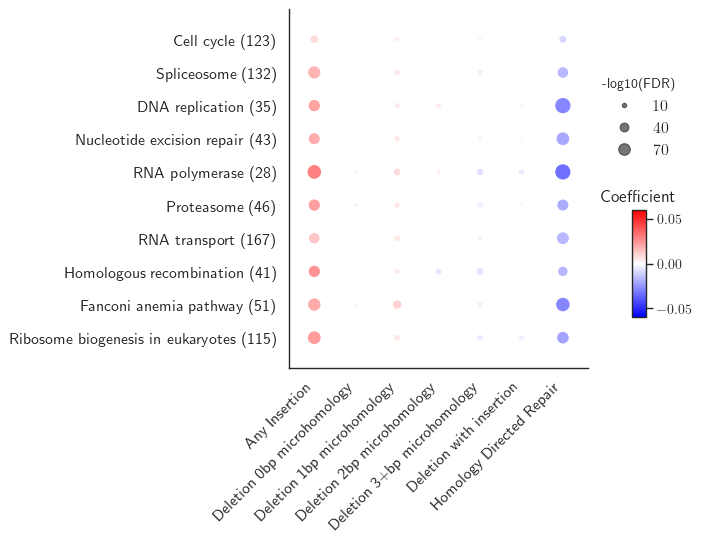

In [19]:
# do plot with Coefficients as circles and pvalues as colors.
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from itertools import product

fig, ax = plt.subplots(figsize=(7.2, 5.6))

sizes_df = np.log(results.xs("corrected", level=1, axis=1))
sizes_df

colors_df = results.xs("Coef", level=1, axis=1)
colors_df

list_1 = list(np.arange(sizes_df.index.shape[0]))
list_2 = list(np.arange(sizes_df.columns.shape[0]))

unique_combinations = []
 
for i in range(len(list_1)):
    for j in range(len(list_2)):
        unique_combinations.append((list_1[i], list_2[j]))
 
dots_df = pd.DataFrame(unique_combinations).rename(columns={0: "Pathway", 1: "Mutation Type"})
dots_df = dots_df.join((-sizes_df).stack().reset_index().rename(columns={0: "-log10(FDR)"}))
dots_df["Coefficient"] = (colors_df).stack().values

vcenter = 0
vmin, vmax = -0.06, 0.06
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.bwr

scatter = ax.scatter(x=dots_df["Mutation Type"],
    y=dots_df["Pathway"],
    s=dots_df["-log10(FDR)"],
    c=dots_df["Coefficient"],
    norm=normalize,
    cmap=colormap)

ax.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(dots_df["level_0"].unique())

ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(dots_df["level_1"].unique(), rotation=45, ha='right')

ax.margins(0.1) 

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles[::3][:3], labels[::3][:3], loc="upper left", title="-log10(FDR)", frameon=False, bbox_to_anchor=(1, .85))
legend2.get_title().set_fontsize('10')

cbar = plt.colorbar(scatter, shrink=0.3, pad=0.11, anchor=(0,.2), aspect=8)
cbar.ax.set_title("Coefficient")
cbar.ax.tick_params(labelsize=10)

# plt.suptitle("Association between pathways and mutation type frequency (MUSIC)")

plt.tight_layout()
plt.show()


In [20]:
# representative_genes = d.loc[~d.index.isin(genes_of_interest)].dropna().index.to_series().sample(200)
representative_genes = d.loc[d.index.isin(controls)].index.to_series()
target_sites = ["T1", "T2", "T3", "Adamson_T1"]
results = {}
for target in target_sites:
    results[target] = {}
    for mutation in d.columns.unique(level=1).sort_values():
        results[target][mutation] = {}
        for p in list(pathway_genes.keys()):
            gene_set = pathway_genes[p]
            num_overlap = len(np.intersect1d(d[target].dropna().index.to_list(), gene_set))
            label = p + " ({})".format(num_overlap)
            if num_overlap < 1:
                results[target][mutation][label] = 1, 0
                continue

            if mutation == "Any Insertion":
                print("Target: ", target, ", Mutation", mutation, ", Pathway", p, ", #gene set", len(gene_set), ", #overlap target site", num_overlap)

            a = d.loc[np.intersect1d(d.index, gene_set)].xs(mutation, level=1, axis=1)[[target]]
            a = a.stack().to_frame().rename(columns={0: "Frequency"})
            a["Group"] = label

            b = d.loc[representative_genes].xs(mutation, level=1, axis=1)[[target]]
            b = b.stack().to_frame().rename(columns={0: "Frequency"})
            b["Group"] = "Control"

            df = pd.concat((b, a)).reset_index().rename(columns={"level_1": "Target"})

            model = ols("Frequency ~ C(Group, Treatment(reference='Control'))", data=df).fit()
            results[target][mutation][label] = model.pvalues[1], model.params[1]
        results[target][mutation] = pd.DataFrame(results[target][mutation]).rename(index={0: "PR(>F)", 1: "Coef"}).T
        rejected, corrected_p_values = fdrcorrection(results[target][mutation]["PR(>F)"], alpha=0.05)
        results[target][mutation]["corrected"] = corrected_p_values
        results[target][mutation]["rejected"] = rejected

            
    results[target] = pd.concat(results[target], axis=1)       

Target:  T1 , Mutation Any Insertion , Pathway Ribosome biogenesis in eukaryotes , #gene set 115 , #overlap target site 42
Target:  T1 , Mutation Any Insertion , Pathway Fanconi anemia pathway , #gene set 51 , #overlap target site 34
Target:  T1 , Mutation Any Insertion , Pathway Homologous recombination , #gene set 41 , #overlap target site 22
Target:  T1 , Mutation Any Insertion , Pathway RNA transport , #gene set 167 , #overlap target site 99
Target:  T1 , Mutation Any Insertion , Pathway Proteasome , #gene set 46 , #overlap target site 20
Target:  T1 , Mutation Any Insertion , Pathway RNA polymerase , #gene set 28 , #overlap target site 9
Target:  T1 , Mutation Any Insertion , Pathway Nucleotide excision repair , #gene set 43 , #overlap target site 27
Target:  T1 , Mutation Any Insertion , Pathway DNA replication , #gene set 35 , #overlap target site 17
Target:  T1 , Mutation Any Insertion , Pathway Spliceosome , #gene set 132 , #overlap target site 74
Target:  T1 , Mutation Any In

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Frequency   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.04000
Date:                Thu, 23 Jan 2025   Prob (F-statistic):              0.842
Time:                        17:23:18   Log-Likelihood:                 291.14
No. Observations:                  91   AIC:                            -578.3
Df Residuals:                      89   BIC:                            -573.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       0.0503      0.001     39.037      0.000       0.048       0.053
C(Group, Treatment(reference='Control'))[T.Cell cycle (31)]    -0.0004      0.002     -0.200      0.842      -0.005       0.004
==============================================================================
Omnibus:                       67.722   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1388.960
Skew:                           1.742   Prob(JB):                    2.46e-302
Kurtosis:                      21.820   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

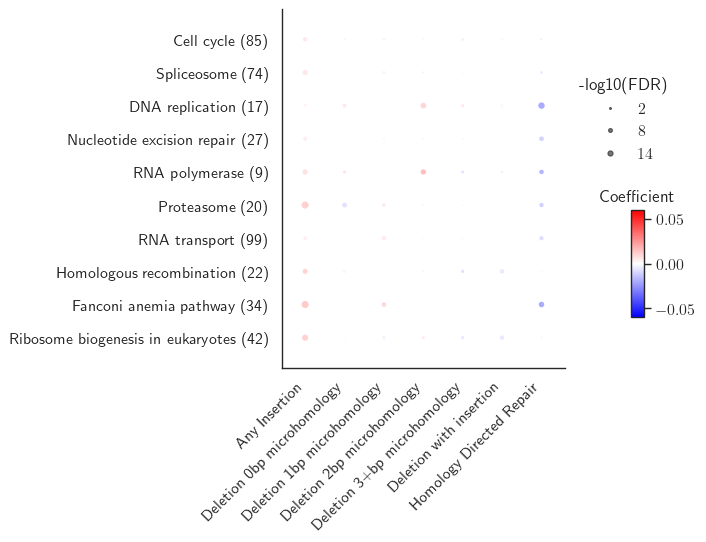

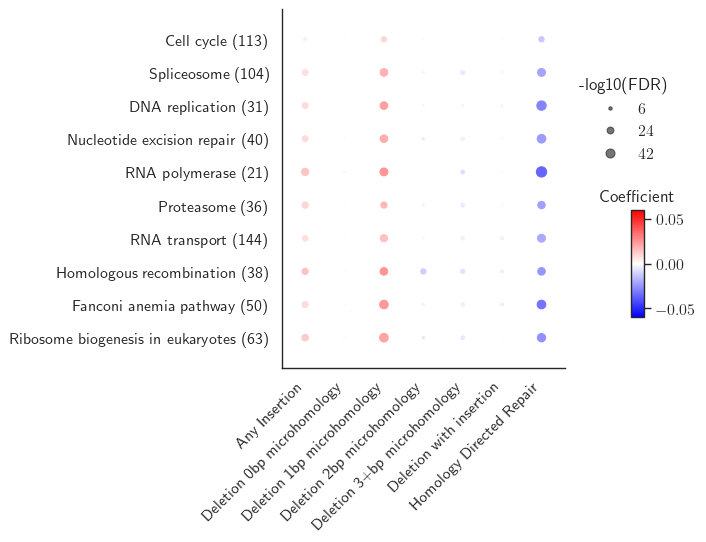

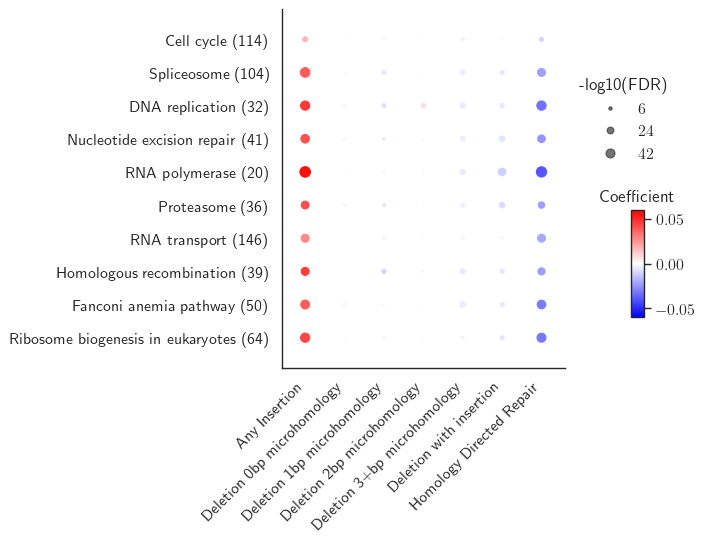

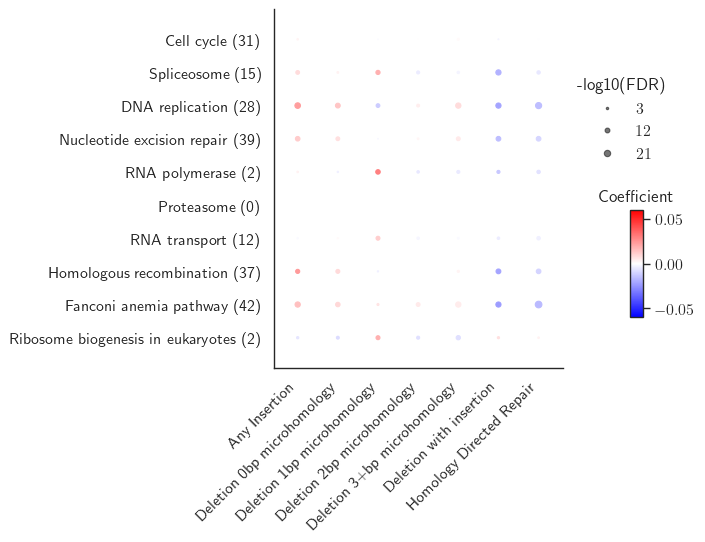

In [22]:
# do plot with Coefficients as circles and pvalues as colors.
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from itertools import product

for target in target_sites:
    fig, ax = plt.subplots(figsize=(7.2, 5.6))

    sizes_df = np.log(results[target].xs("corrected", level=1, axis=1))
    sizes_df

    colors_df = results[target].xs("Coef", level=1, axis=1)
    colors_df

    list_1 = list(np.arange(sizes_df.index.shape[0]))
    list_2 = list(np.arange(sizes_df.columns.shape[0]))

    unique_combinations = []
    
    for i in range(len(list_1)):
        for j in range(len(list_2)):
            unique_combinations.append((list_1[i], list_2[j]))
    
    dots_df = pd.DataFrame(unique_combinations).rename(columns={0: "Pathway", 1: "Mutation Type"})
    dots_df = dots_df.join((-sizes_df).stack().reset_index().rename(columns={0: "-log10(FDR)"}))
    dots_df["Coefficient"] = (colors_df).stack().values

    vcenter = 0
    vmin, vmax = -0.06, 0.06
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    colormap = cm.bwr

    scatter = ax.scatter(x=dots_df["Mutation Type"],
        y=dots_df["Pathway"],
        s=dots_df["-log10(FDR)"],
        c=dots_df["Coefficient"],
        norm=normalize,
        cmap=colormap)

    ax.set_yticks(np.arange(0, dots_df["level_0"].unique().shape[0]))
    ax.set_yticklabels(dots_df["level_0"].unique())

    ax.set_xticks(np.arange(0, dots_df["level_1"].unique().shape[0]))
    ax.set_xticklabels(dots_df["level_1"].unique(), rotation=45, ha='right')

    ax.margins(0.1) 

    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    legend2 = ax.legend(handles[::3][:3], labels[::3][:3], loc="upper left", title="-log10(FDR)", frameon=False, bbox_to_anchor=(1, .85))

    cbar = plt.colorbar(scatter, shrink=0.3, pad=0.16, anchor=(0,.2), aspect=8)
    cbar.ax.set_title("Coefficient")

    # plt.suptitle("Association between pathways and mutation type frequency (repair-seq)")

    plt.tight_layout()
plt.show()


In [23]:
results["T1"]

Any Insertion                          \
                                              PR(>F)      Coef     corrected   
Ribosome biogenesis in eukaryotes (42)  6.045208e-07  0.010682  2.015069e-06   
Fanconi anemia pathway (34)             8.834842e-10  0.012208  8.834842e-09   
Homologous recombination (22)           2.586200e-04  0.010148  4.310333e-04   
RNA transport (99)                      3.033064e-02  0.003529  3.370071e-02   
Proteasome (20)                         2.920466e-09  0.010975  1.460233e-08   
RNA polymerase (9)                      4.693799e-05  0.006640  1.173450e-04   
Nucleotide excision repair (27)         7.972195e-03  0.004192  9.965244e-03   
DNA replication (17)                    1.071134e-01  0.002790  1.071134e-01   
Spliceosome (74)                        7.919176e-05  0.005502  1.583835e-04   
Cell cycle (85)                         3.360111e-03  0.005347  4.800159e-03   

                                                Deletion 0bp microhomology  \
                                       rejected                     PR(>F)   
Ribosome biogenesis in eukaryotes (42)     True                   0.462782   
Fanconi anemia pathway (34)                True                   0.575601   
Homologous recombination (22)              True                   0.071103   
RNA transport (99)                         True                   0.787261   
Proteasome (20)                            True                   0.000093   
RNA polymerase (9)                         True                   0.032013   
Nucleotide excision repair (27)            True                   0.891373   
DNA replication (17)                      False                   0.002303   
Spliceosome (74)                           True                   0.585410   
Cell cycle (85)                            True                   0.170574   

                                                                     \
                                            Coef corrected rejected   
Ribosome biogenesis in eukaryotes (42)  0.001229  0.731763    False   
Fanconi anemia pathway (34)             0.000817  0.731763    False   
Homologous recombination (22)           0.003052  0.177758    False   
RNA transport (99)                     -0.000415  0.874735    False   
Proteasome (20)                        -0.006821  0.000928     True   
RNA polymerase (9)                      0.006522  0.106709    False   
Nucleotide excision repair (27)         0.000201  0.891373    False   
DNA replication (17)                    0.005155  0.011516     True   
Spliceosome (74)                        0.001007  0.731763    False   
Cell cycle (85)                        -0.002095  0.341148    False   

                                       Deletion 1bp microhomology            \
                                                           PR(>F)      Coef   
Ribosome biogenesis in eukaryotes (42)                   0.062352 -0.003283   
Fanconi anemia pathway (34)                              0.000204  0.008996   
Homologous recombination (22)                            0.664840 -0.000924   
RNA transport (99)                                       0.002183  0.004939   
Proteasome (20)                                          0.013627  0.005205   
RNA polymerase (9)                                       0.555673 -0.001304   
Nucleotide excision repair (27)                          0.270899  0.002187   
DNA replication (17)                                     0.864012 -0.000380   
Spliceosome (74)                                         0.100458  0.002938   
Cell cycle (85)                                          0.089353  0.002951   

                                        ... Deletion 3+bp microhomology  \
                                        ...                   corrected   
Ribosome biogenesis in eukaryotes (42)  ...                    0.133462   
Fanconi anemia pathway (34)             ...                    0.653374   
Homologous recombination (22)          

24.862524982466166
T1 (0, 0)
T2 (1, 0)
T3 (1, 1)
Adamson_T1 (0, 1)


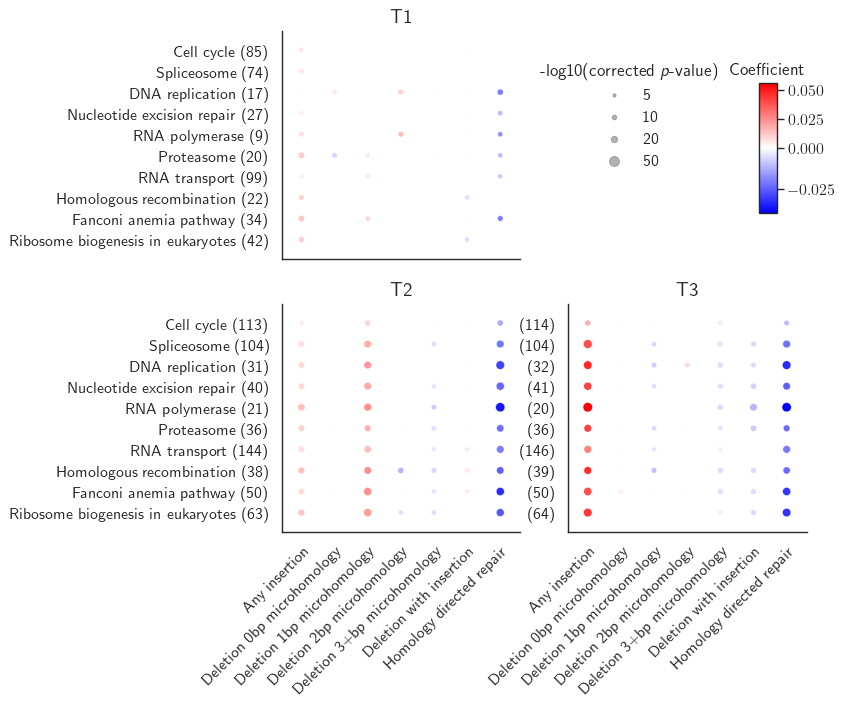

In [27]:
# do plot with Coefficients as circles and pvalues as colors.
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from itertools import product

all_handles = []

fig, axes = plt.subplots(2, 2, figsize=(6, 6.5))

max_corrected = 0
min_corrected = 10000000

max_coef = 0
min_coef = 10000000
for target in target_sites:
    max_corrected = np.max((max_corrected, (-np.log10(results[target].xs("corrected", level=1, axis=1))).max().max()))
    min_corrected = np.min((min_corrected, (-np.log10(results[target].xs("corrected", level=1, axis=1))).min().min()))

    max_coef = np.max((max_coef, (results[target].xs("Coef", level=1, axis=1)).max().max()))
    min_coef = np.min((min_coef, (results[target].xs("Coef", level=1, axis=1)).min().min()))

print(max_corrected)

for target, idx in zip(target_sites, [(0, 0), (1, 0), (1, 1), (0, 1)]):
    print(target, idx)

    ax = axes[idx]

    if target == "Adamson_T1":
        ax.set_axis_off()
        continue

    sizes_df = np.log10(results[target].xs("corrected", level=1, axis=1))
    sizes_df

    colors_df = results[target].xs("Coef", level=1, axis=1)
    colors_df

    list_1 = list(np.arange(sizes_df.index.shape[0]))
    list_2 = list(np.arange(sizes_df.columns.shape[0]))

    unique_combinations = []
    
    for i in range(len(list_1)):
        for j in range(len(list_2)):
            unique_combinations.append((list_1[i], list_2[j]))

    dots_df = pd.DataFrame(unique_combinations).rename(columns={0: "Pathway", 1: "Mutation Type"})
    dots_df = dots_df.join((-sizes_df).stack().reset_index().rename(columns={0: "-log10(p_cor)"}))
    dots_df["Coefficient"] = (colors_df).stack().values
    dots_df.loc[dots_df["-log10(p_cor)"] < -np.log10(0.05), "Coefficient"] = 0

    max_size = max_corrected
    min_size = 1

    vcenter = 0
    vmin, vmax = min_coef, max_coef
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    colormap = cm.bwr

    scatter = sns.scatterplot(x=dots_df["Mutation Type"],
        y=dots_df["Pathway"],
        size=dots_df["-log10(p_cor)"],
        size_norm=(min_size, max_size),
        hue=dots_df["Coefficient"],
        hue_norm=normalize,
        palette=colormap, 
        legend=False,
        ax=ax)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_yticks(np.arange(0, dots_df["level_0"].unique().shape[0]))
    if idx[1] == 0:
        ax.set_yticklabels(dots_df["level_0"].unique())
    else:
        ax.set_yticklabels([l.split()[-1] for l in dots_df["level_0"].unique()])

    ax.set_xticks(np.arange(0, dots_df["level_1"].unique().shape[0]))
    if idx[0] == 1:
        ax.set_xticklabels(np.char.capitalize(list(dots_df["level_1"].unique())), rotation=45, ha='right', rotation_mode="anchor")
    else:
        ax.set_xticklabels([])

    ax.margins(0.1) 

    # handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    # handles, labels = ax.get_legend_handles_labels()
    # idx_legend = labels.index('-log10(p_cor)')
    # handles = handles[(idx_legend + 1):]
    # labels = labels[(idx_legend + 1):]
    # legend = ax.legend(handles[1::2][:3], labels[1::2][:3], loc="upper left", title="-log10(p_cor)", frameon=False, bbox_to_anchor=(1, 1))

    # sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
    # sm.set_array([])

    # cbar = plt.colorbar(sm, shrink=0.3, pad=0.15, anchor=(0,.1), aspect=8, ax=ax)
    # cbar.ax.set_title("Coefficient")

axes[0, 0].set_title("T1", fontsize=14)
axes[1, 0].set_title("T2", fontsize=14)
axes[1, 1].set_title("T3", fontsize=14)
# axes[0, 1].set_title("repair-seq", fontsize=14)

# colorplot
fig.subplots_adjust(right=1)
cbar_ax = fig.add_axes([0.92, 0.6, 0.03, 0.2])
fig.colorbar(
    mpl.cm.ScalarMappable(norm=normalize, cmap=colormap)
    , aspect=8, cax=cbar_ax, shrink=0.3, pad=0.3, anchor=(0,0))
cbar_ax.set_title("Coefficient")

# legend
legend_sizes = [5, 10, 20, 50]
legend_handles = [plt.scatter([], [], s=size, color="gray", alpha=0.6) for size in legend_sizes]
legend_labels = [f'{size}' for size in legend_sizes]
fig.legend(legend_handles, legend_labels, loc='center right', title=r"-log10(corrected \textit{p}-value)", frameon=False, bbox_to_anchor=(0.875, 0.75))
# plt.tight_layout()

# plt.suptitle("Association between KEGG pathways and mutation type frequency", fontsize=16)
plt.gcf().savefig("artifacts/OLS.pdf", bbox_inches='tight')


In [25]:
results["T1"]

Any Insertion                          \
                                              PR(>F)      Coef     corrected   
Ribosome biogenesis in eukaryotes (42)  6.045208e-07  0.010682  2.015069e-06   
Fanconi anemia pathway (34)             8.834842e-10  0.012208  8.834842e-09   
Homologous recombination (22)           2.586200e-04  0.010148  4.310333e-04   
RNA transport (99)                      3.033064e-02  0.003529  3.370071e-02   
Proteasome (20)                         2.920466e-09  0.010975  1.460233e-08   
RNA polymerase (9)                      4.693799e-05  0.006640  1.173450e-04   
Nucleotide excision repair (27)         7.972195e-03  0.004192  9.965244e-03   
DNA replication (17)                    1.071134e-01  0.002790  1.071134e-01   
Spliceosome (74)                        7.919176e-05  0.005502  1.583835e-04   
Cell cycle (85)                         3.360111e-03  0.005347  4.800159e-03   

                                                Deletion 0bp microhomology  \
                                       rejected                     PR(>F)   
Ribosome biogenesis in eukaryotes (42)     True                   0.462782   
Fanconi anemia pathway (34)                True                   0.575601   
Homologous recombination (22)              True                   0.071103   
RNA transport (99)                         True                   0.787261   
Proteasome (20)                            True                   0.000093   
RNA polymerase (9)                         True                   0.032013   
Nucleotide excision repair (27)            True                   0.891373   
DNA replication (17)                      False                   0.002303   
Spliceosome (74)                           True                   0.585410   
Cell cycle (85)                            True                   0.170574   

                                                                     \
                                            Coef corrected rejected   
Ribosome biogenesis in eukaryotes (42)  0.001229  0.731763    False   
Fanconi anemia pathway (34)             0.000817  0.731763    False   
Homologous recombination (22)           0.003052  0.177758    False   
RNA transport (99)                     -0.000415  0.874735    False   
Proteasome (20)                        -0.006821  0.000928     True   
RNA polymerase (9)                      0.006522  0.106709    False   
Nucleotide excision repair (27)         0.000201  0.891373    False   
DNA replication (17)                    0.005155  0.011516     True   
Spliceosome (74)                        0.001007  0.731763    False   
Cell cycle (85)                        -0.002095  0.341148    False   

                                       Deletion 1bp microhomology            \
                                                           PR(>F)      Coef   
Ribosome biogenesis in eukaryotes (42)                   0.062352 -0.003283   
Fanconi anemia pathway (34)                              0.000204  0.008996   
Homologous recombination (22)                            0.664840 -0.000924   
RNA transport (99)                                       0.002183  0.004939   
Proteasome (20)                                          0.013627  0.005205   
RNA polymerase (9)                                       0.555673 -0.001304   
Nucleotide excision repair (27)                          0.270899  0.002187   
DNA replication (17)                                     0.864012 -0.000380   
Spliceosome (74)                                         0.100458  0.002938   
Cell cycle (85)                                          0.089353  0.002951   

                                        ... Deletion 3+bp microhomology  \
                                        ...                   corrected   
Ribosome biogenesis in eukaryotes (42)  ...                    0.133462   
Fanconi anemia pathway (34)             ...                    0.653374   
Homologous recombination (22)          

In [26]:
top_BP_enr = pd.read_csv("artifacts/tophits/GO_Biological_Process_2023.mouse.enrichr.reports.txt", sep="\t").iloc[:10]
BP_genes = {}
for i in range(10):
    BP_genes[top_BP_enr["Term"][i]] = [g.capitalize() for g in top_BP_enr["Genes"][i].split(";")]
genes_of_interest = np.unique(np.concatenate(list(BP_genes.values())).ravel())

# representative_genes = d.loc[~d.index.isin(genes_of_interest)].dropna().index.to_series().sample(200)
representative_genes = d.loc[d.index.isin(controls)].index.to_series()

target_sites = ["T1", "T2", "T3", "Adamson_T1"]
results = {}
for target in target_sites:
    results[target] = {}
    for mutation in d.columns.unique(level=1).sort_values():
        results[target][mutation] = {}
        for p in list(BP_genes.keys()):
            gene_set = BP_genes[p]
            num_overlap = len(np.intersect1d(d[target].dropna().index.to_list(), gene_set))
            label = p.split("(")[0] + " ({})".format(num_overlap)

            if num_overlap < 9:
                results[target][mutation][label] = 1, 0
                continue

            a = d.loc[np.intersect1d(d.index, gene_set)].xs(mutation, level=1, axis=1)[[target]]
            a = a.stack().to_frame().rename(columns={0: "Frequency"})
            a["Group"] = label

            b = d.loc[representative_genes].xs(mutation, level=1, axis=1)[[target]]
            b = b.stack().to_frame().rename(columns={0: "Frequency"})
            b["Group"] = "Control"

            df = pd.concat((b, a)).reset_index().rename(columns={"level_1": "Target"})

            model = ols("Frequency ~ C(Group, Treatment(reference='Control'))", data=df).fit()
            results[target][mutation][label] = model.pvalues[1], model.params[1]
        results[target][mutation] = pd.DataFrame(results[target][mutation]).rename(index={0: "PR(>F)", 1: "Coef"}).T
        rejected, corrected_p_values = fdrcorrection(results[target][mutation]["PR(>F)"], alpha=0.05)
        results[target][mutation]["corrected"] = corrected_p_values
        results[target][mutation]["rejected"] = rejected

    results[target] = pd.concat(results[target], axis=1)  

T1 (0, 0)
T2 (0, 1)
T3 (1, 0)
Adamson_T1 (1, 1)


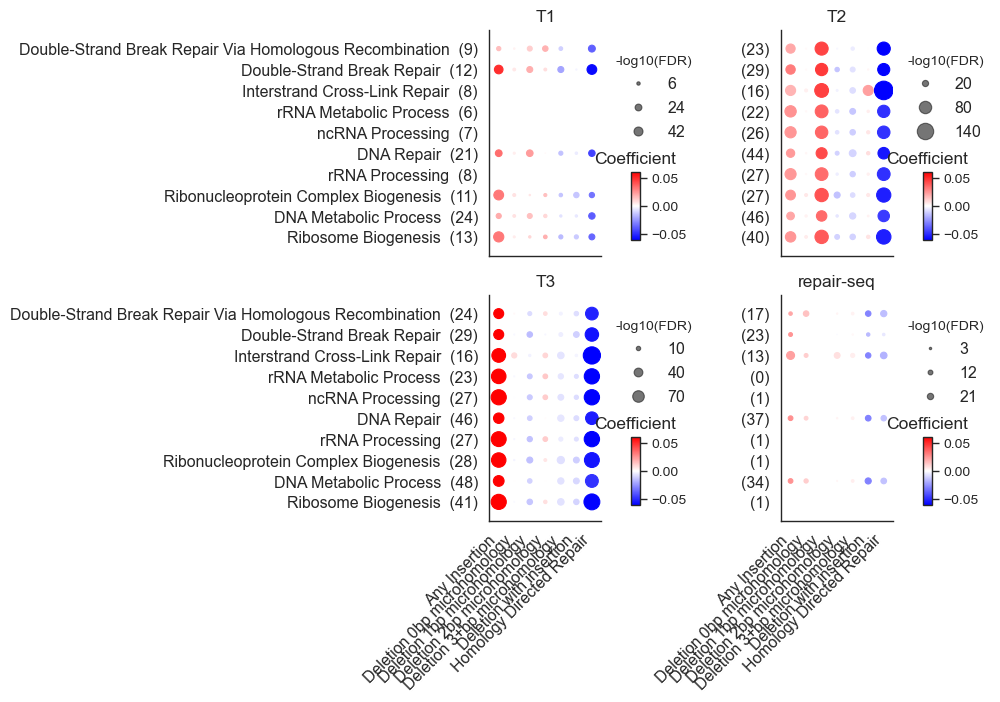

In [27]:
# do plot with Coefficients as circles and pvalues as colors.
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from itertools import product


fig, axes = plt.subplots(2, 2, figsize=(9.8, 7.2))

for target, idx in zip(target_sites, [(0, 0), (0, 1), (1, 0), (1, 1)]):
    print(target, idx)

    ax = axes[idx]

    sizes_df = np.log(results[target].xs("corrected", level=1, axis=1))
    sizes_df

    colors_df = results[target].xs("Coef", level=1, axis=1)
    colors_df

    list_1 = list(np.arange(sizes_df.index.shape[0]))
    list_2 = list(np.arange(sizes_df.columns.shape[0]))

    unique_combinations = []
    
    for i in range(len(list_1)):
        for j in range(len(list_2)):
            unique_combinations.append((list_1[i], list_2[j]))

    dots_df = pd.DataFrame(unique_combinations).rename(columns={0: "MF", 1: "Mutation Type"})
    dots_df = dots_df.join((-sizes_df).stack().reset_index().rename(columns={0: "-log10(FDR)"}))
    dots_df["Coefficient"] = (colors_df).stack().values

    vcenter = 0
    vmin, vmax = -0.06, 0.06
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    colormap = cm.bwr

    scatter = ax.scatter(x=dots_df["Mutation Type"],
        y=dots_df["MF"],
        s=dots_df["-log10(FDR)"],
        c=dots_df["Coefficient"],
        norm=normalize,
        cmap=colormap)

    ax.set_yticks(np.arange(0, dots_df["level_0"].unique().shape[0]))
    if idx[1] == 0:
        ax.set_yticklabels(dots_df["level_0"].unique())
    else:
        ax.set_yticklabels([l.split()[-1] for l in dots_df["level_0"].unique()])

    ax.set_xticks(np.arange(0, dots_df["level_1"].unique().shape[0]))
    if idx[0] == 1:
        ax.set_xticklabels(dots_df["level_1"].unique(), rotation=45, ha='right')
    else:
        ax.set_xticklabels([])

    ax.margins(0.1) 

    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    legend2 = ax.legend(handles[::3][:3], labels[::3][:3], loc="upper left", title="-log10(FDR)", frameon=False, bbox_to_anchor=(1, .95))
    legend2.get_title().set_fontsize('10')

    cbar = plt.colorbar(scatter, shrink=0.3, pad=0.18, anchor=(0,.1), aspect=8)
    cbar.ax.set_title("Coefficient", )
    cbar.ax.tick_params(labelsize=10)

axes[0, 0].set_title("T1")
axes[0, 1].set_title("T2")
axes[1, 0].set_title("T3")
axes[1, 1].set_title("repair-seq")

# plt.suptitle("Association between Molecular Functions and mutation type frequency")
plt.tight_layout()
plt.show()
# plt.gcf().savefig("artifacts/fig_4.pdf")
# plt.gcf().savefig("artifacts/fig_4.png")


In [28]:
top_MF_enr = pd.read_csv("artifacts/tophits/GO_Molecular_Function_2023.mouse.enrichr.reports.txt", sep="\t").iloc[:10]
MF_genes = {}
for i in range(10):
    MF_genes[top_MF_enr["Term"][i]] = [g.capitalize() for g in top_MF_enr["Genes"][i].split(";")]
genes_of_interest = np.unique(np.concatenate(list(MF_genes.values())).ravel())

# representative_genes = d.loc[~d.index.isin(genes_of_interest)].dropna().index.to_series().sample(200)
representative_genes = d.loc[d.index.isin(controls)].index.to_series()

target_sites = ["T1", "T2", "T3", "Adamson_T1"]
results = {}
for target in target_sites:
    results[target] = {}
    for mutation in d.columns.unique(level=1).sort_values():
        results[target][mutation] = {}
        for p in list(MF_genes.keys()):
            gene_set = MF_genes[p]
            num_overlap = len(np.intersect1d(d[target].dropna().index.to_list(), gene_set))
            label = p.split("(")[0] + " ({})".format(num_overlap)

            if num_overlap < 9:
                results[target][mutation][label] = 1, 0
                continue

            a = d.loc[np.intersect1d(d.index, gene_set)].xs(mutation, level=1, axis=1)[[target]]
            a = a.stack().to_frame().rename(columns={0: "Frequency"})
            a["Group"] = label

            b = d.loc[representative_genes].xs(mutation, level=1, axis=1)[[target]]
            b = b.stack().to_frame().rename(columns={0: "Frequency"})
            b["Group"] = "Control"

            df = pd.concat((b, a)).reset_index().rename(columns={"level_1": "Target"})

            model = ols("Frequency ~ C(Group, Treatment(reference='Control'))", data=df).fit()
            results[target][mutation][label] = model.pvalues[1], model.params[1]
        results[target][mutation] = pd.DataFrame(results[target][mutation]).rename(index={0: "PR(>F)", 1: "Coef"}).T
        rejected, corrected_p_values = fdrcorrection(results[target][mutation]["PR(>F)"], alpha=0.05)
        results[target][mutation]["corrected"] = corrected_p_values
        results[target][mutation]["rejected"] = rejected

    results[target] = pd.concat(results[target], axis=1)  

T1 (0, 0)
T2 (0, 1)
T3 (1, 0)
Adamson_T1 (1, 1)


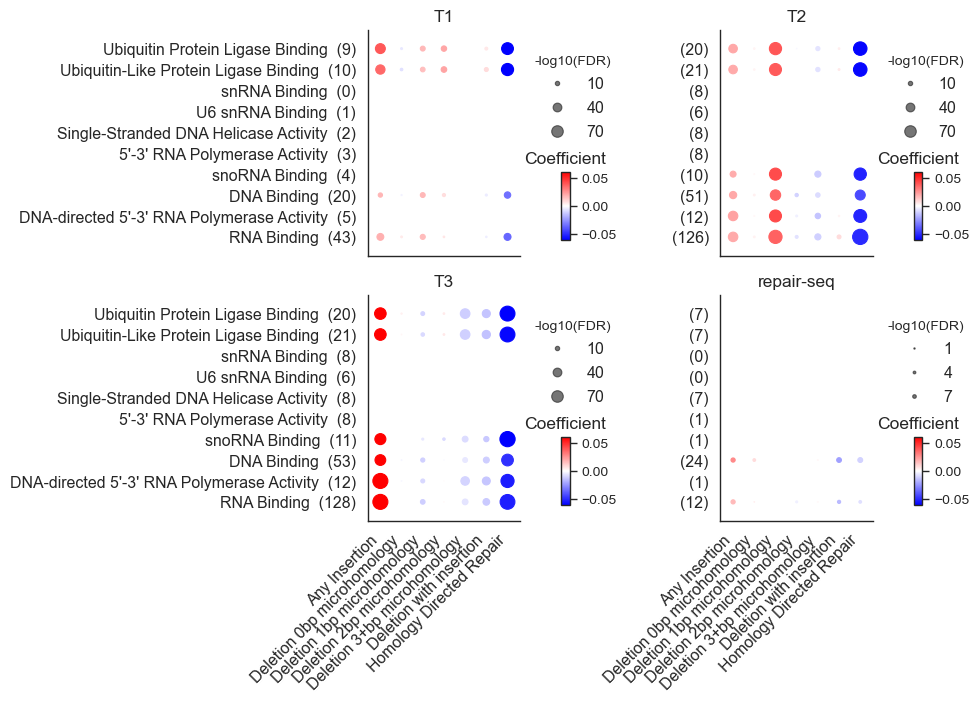

In [29]:
# do plot with Coefficients as circles and pvalues as colors.
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from itertools import product


fig, axes = plt.subplots(2, 2, figsize=(9.8, 7.2))

for target, idx in zip(target_sites, [(0, 0), (0, 1), (1, 0), (1, 1)]):
    print(target, idx)

    ax = axes[idx]

    sizes_df = np.log(results[target].xs("corrected", level=1, axis=1))
    sizes_df

    colors_df = results[target].xs("Coef", level=1, axis=1)
    colors_df

    list_1 = list(np.arange(sizes_df.index.shape[0]))
    list_2 = list(np.arange(sizes_df.columns.shape[0]))

    unique_combinations = []
    
    for i in range(len(list_1)):
        for j in range(len(list_2)):
            unique_combinations.append((list_1[i], list_2[j]))

    dots_df = pd.DataFrame(unique_combinations).rename(columns={0: "MF", 1: "Mutation Type"})
    dots_df = dots_df.join((-sizes_df).stack().reset_index().rename(columns={0: "-log10(FDR)"}))
    dots_df["Coefficient"] = (colors_df).stack().values

    vcenter = 0
    vmin, vmax = -0.06, 0.06
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    colormap = cm.bwr

    scatter = ax.scatter(x=dots_df["Mutation Type"],
        y=dots_df["MF"],
        s=dots_df["-log10(FDR)"],
        c=dots_df["Coefficient"],
        norm=normalize,
        cmap=colormap)

    ax.set_yticks(np.arange(0, dots_df["level_0"].unique().shape[0]))
    if idx[1] == 0:
        ax.set_yticklabels(dots_df["level_0"].unique())
    else:
        ax.set_yticklabels([l.split()[-1] for l in dots_df["level_0"].unique()])

    ax.set_xticks(np.arange(0, dots_df["level_1"].unique().shape[0]))
    if idx[0] == 1:
        ax.set_xticklabels(dots_df["level_1"].unique(), rotation=45, ha='right')
    else:
        ax.set_xticklabels([])

    ax.margins(0.1) 

    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    legend2 = ax.legend(handles[::3][:3], labels[::3][:3], loc="upper left", title="-log10(FDR)", frameon=False, bbox_to_anchor=(1, .95), )
    legend2.get_title().set_fontsize('10')

    cbar = plt.colorbar(scatter, shrink=0.3, pad=0.18, anchor=(0,.1), aspect=8)
    cbar.ax.set_title("Coefficient", )
    cbar.ax.tick_params(labelsize=10)

axes[0, 0].set_title("T1")
axes[0, 1].set_title("T2")
axes[1, 0].set_title("T3")
axes[1, 1].set_title("repair-seq")

# plt.suptitle("Association between Molecular Functions and mutation type frequency")
plt.tight_layout()
plt.show()
# plt.gcf().savefig("artifacts/fig_4.pdf")
# plt.gcf().savefig("artifacts/fig_4.png")


In [30]:
top_CC_enr = pd.read_csv("artifacts/tophits/GO_Cellular_Component_2023.mouse.enrichr.reports.txt", sep="\t").iloc[:10]
CC_genes = {}
for i in range(10):
    CC_genes[top_CC_enr["Term"][i]] = [g.capitalize() for g in top_CC_enr["Genes"][i].split(";")]
genes_of_interest = np.unique(np.concatenate(list(CC_genes.values())).ravel())

# representative_genes = d.loc[~d.index.isin(genes_of_interest)].dropna().index.to_series().sample(200)
representative_genes = d.loc[d.index.isin(controls)].index.to_series()

target_sites = ["T1", "T2", "T3", "Adamson_T1"]
results = {}
for target in target_sites:
    results[target] = {}
    for mutation in d.columns.unique(level=1).sort_values():
        results[target][mutation] = {}
        for p in list(CC_genes.keys()):
            gene_set = CC_genes[p]
            num_overlap = len(np.intersect1d(d[target].dropna().index.to_list(), gene_set))
            label = p.split("(")[0] + " ({})".format(num_overlap)

            if num_overlap < 9:
                results[target][mutation][label] = 1, 0
                continue

            a = d.loc[np.intersect1d(d.index, gene_set)].xs(mutation, level=1, axis=1)[[target]]
            a = a.stack().to_frame().rename(columns={0: "Frequency"})
            a["Group"] = label

            b = d.loc[representative_genes].xs(mutation, level=1, axis=1)[[target]]
            b = b.stack().to_frame().rename(columns={0: "Frequency"})
            b["Group"] = "Control"

            df = pd.concat((b, a)).reset_index().rename(columns={"level_1": "Target"})

            model = ols("Frequency ~ C(Group, Treatment(reference='Control'))", data=df).fit()
            results[target][mutation][label] = model.pvalues[1], model.params[1]
        results[target][mutation] = pd.DataFrame(results[target][mutation]).rename(index={0: "PR(>F)", 1: "Coef"}).T
        rejected, corrected_p_values = fdrcorrection(results[target][mutation]["PR(>F)"], alpha=0.05)
        results[target][mutation]["corrected"] = corrected_p_values
        results[target][mutation]["rejected"] = rejected

    results[target] = pd.concat(results[target], axis=1)    

T1 (0, 0)
T2 (0, 1)
T3 (1, 0)
Adamson_T1 (1, 1)


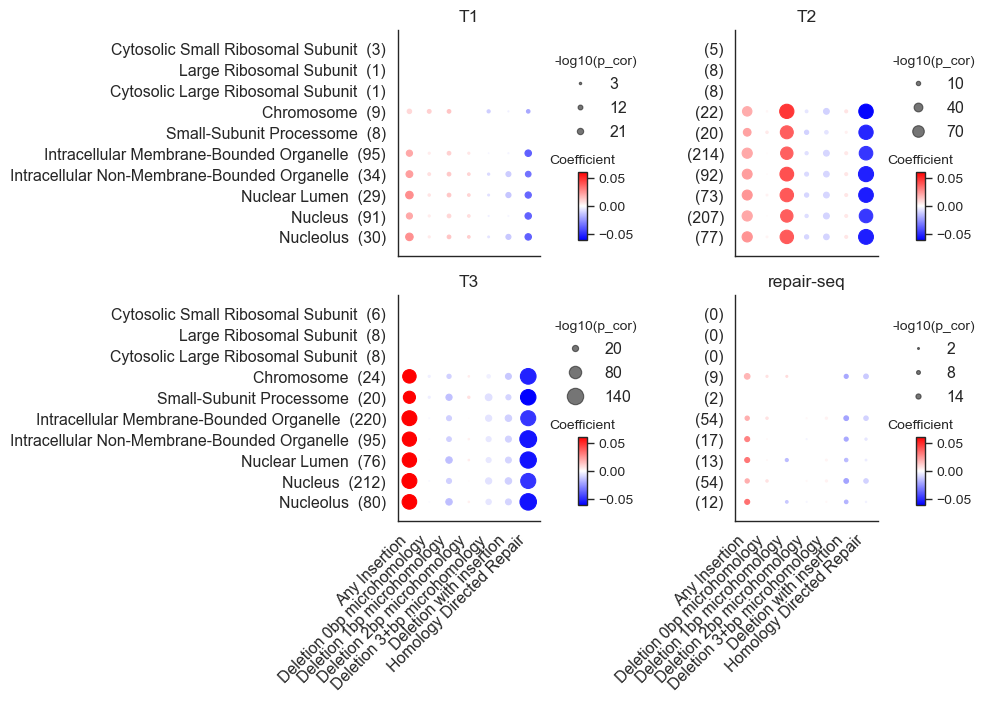

In [31]:
# do plot with Coefficients as circles and pvalues as colors.
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from itertools import product


fig, axes = plt.subplots(2, 2, figsize=(9.8, 7.2))

for target, idx in zip(target_sites, [(0, 0), (0, 1), (1, 0), (1, 1)]):
    print(target, idx)

    ax = axes[idx]

    sizes_df = np.log(results[target].xs("corrected", level=1, axis=1))
    sizes_df

    colors_df = results[target].xs("Coef", level=1, axis=1)
    colors_df

    list_1 = list(np.arange(sizes_df.index.shape[0]))
    list_2 = list(np.arange(sizes_df.columns.shape[0]))

    unique_combinations = []
    
    for i in range(len(list_1)):
        for j in range(len(list_2)):
            unique_combinations.append((list_1[i], list_2[j]))

    dots_df = pd.DataFrame(unique_combinations).rename(columns={0: "MF", 1: "Mutation Type"})
    dots_df = dots_df.join((-sizes_df).stack().reset_index().rename(columns={0: "-log10(p_cor)"}))
    dots_df["Coefficient"] = (colors_df).stack().values

    vcenter = 0
    vmin, vmax = -0.06, 0.06
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    colormap = cm.bwr

    scatter = ax.scatter(x=dots_df["Mutation Type"],
        y=dots_df["MF"],
        s=dots_df["-log10(p_cor)"],
        c=dots_df["Coefficient"],
        norm=normalize,
        cmap=colormap)

    ax.set_yticks(np.arange(0, dots_df["level_0"].unique().shape[0]))
    if idx[1] == 0:
        ax.set_yticklabels(dots_df["level_0"].unique())
    else:
        ax.set_yticklabels([l.split()[-1] for l in dots_df["level_0"].unique()])

    ax.set_xticks(np.arange(0, dots_df["level_1"].unique().shape[0]))
    if idx[0] == 1:
        ax.set_xticklabels(dots_df["level_1"].unique(), rotation=45, ha='right')
    else:
        ax.set_xticklabels([])

    ax.margins(0.1) 

    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    legend2 = ax.legend(handles[::3][:3], labels[::3][:3], loc="upper left", title="-log10(p_cor)", frameon=False, bbox_to_anchor=(1, .95))
    legend2.get_title().set_fontsize('10')

    cbar = plt.colorbar(scatter, shrink=0.3, pad=0.18, anchor=(0,.1), aspect=8)
    cbar.ax.set_title("Coefficient", fontsize=10)
    cbar.ax.tick_params(labelsize=10)

axes[0, 0].set_title("T1")
axes[0, 1].set_title("T2")
axes[1, 0].set_title("T3")
axes[1, 1].set_title("repair-seq")

# plt.suptitle("Association between Cellular Components and mutation type frequency")
plt.tight_layout()
plt.show()
# plt.gcf().savefig("artifacts/fig_4.pdf")
# plt.gcf().savefig("artifacts/fig_4.png")
